In [1]:
import os
import torch
from torch import nn
import numpy as np
import copy
import gc
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = "cuda"
current_dir = os.getcwd()
print("Current Directory:", current_dir)

Current Directory: /root/projects/FCL/draw/pca


In [2]:
def load_full_test_data(datadir, dataset="IMAGENET1k", train_images_per_class=5000, test_images_per_class=1000, concat_every=5):
    if dataset == "CIFAR100":
        classes = list(range(100))
    elif dataset == "CIFAR10":
        classes = list(range(10))
    elif dataset == "IMAGENET1k":
        classes = list(range(1000))
    else:
        raise NotImplementedError("Not supported dataset")

    x_test_all = None
    y_test_all = None

    x_test_list, y_test_list = [], []

    for i, _class in enumerate(classes):
        print(f"Loading data full for class {_class}...")
        data_file = datadir + str(_class) + '.npy'
        data = np.load(data_file)  

        new_x_test = data[train_images_per_class:]  
        new_y_test = np.full((test_images_per_class,), _class, dtype=np.int64)

        x_test_list.append(new_x_test)
        y_test_list.append(new_y_test)

        # Mỗi concat_every class thì concat để giảm bộ nhớ
        if (i + 1) % concat_every == 0 or (i + 1) == len(classes):

            if x_test_all is None:
                x_test_all = np.concatenate(x_test_list, axis=0)
                y_test_all = np.concatenate(y_test_list, axis=0)
            else:
                x_test_all = np.concatenate([x_test_all] + x_test_list, axis=0)
                y_test_all = np.concatenate([y_test_all] + y_test_list, axis=0)

            # Giải phóng bộ nhớ
            x_test_list.clear()
            y_test_list.clear()
            gc.collect()

    # Convert sang tensor
    x_test_tensor = torch.tensor(x_test_all, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_all, dtype=torch.long)

    print(f"Loaded {len(x_test_tensor)} test images and {len(y_test_tensor)} test labels.")
    return x_test_tensor, y_test_tensor

In [3]:
# TODO Model Initialization
class FedAvgCNN(nn.Module):
    def __init__(self, in_features=1, num_classes=10, dim=1024):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features,
                        32,
                        kernel_size=5,
                        padding=0,
                        stride=1,
                        bias=True),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,
                        64,
                        kernel_size=5,
                        padding=0,
                        stride=1,
                        bias=True),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.fc1 = nn.Sequential(
            nn.Linear(dim, 512), 
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc(out)
        return out

class BaseHeadSplit(nn.Module):
    def __init__(self, base, head):
        super(BaseHeadSplit, self).__init__()

        self.base = base
        self.head = head
        
    def forward(self, x):
        out = self.base(x)
        out = self.head(out)

        return out

    def get_proto(self, x):
        hidden = self.base(x)
        out    = self.head(hidden)

        return hidden, out


model = FedAvgCNN(in_features=3, num_classes=1000, dim=1600).to(device)
head = copy.deepcopy(model.fc)
model.fc = nn.Identity()
model = BaseHeadSplit(model, head)

In [6]:
x_test_tensor, y_test_tensor = load_full_test_data(
    datadir='/root/projects/FCL/dataset/cifar10-classes/',
    dataset="CIFAR10",
    train_images_per_class=5000,
    test_images_per_class=1000
)

# Wrap in a dataset and dataloader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Loading data full for class 0...
Loading data full for class 1...
Loading data full for class 2...
Loading data full for class 3...
Loading data full for class 4...
Loading data full for class 5...
Loading data full for class 6...
Loading data full for class 7...
Loading data full for class 8...
Loading data full for class 9...
Loaded 10000 test images and 10000 test labels.


In [9]:
import os
import torch
from torch import nn
import numpy as np
import copy
import gc
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = "cuda"
current_dir = os.getcwd()
print("Current Directory:", current_dir)

Current Directory: /home/skydvn/Documents/git/ContinualLearning/FCL/draw/pca


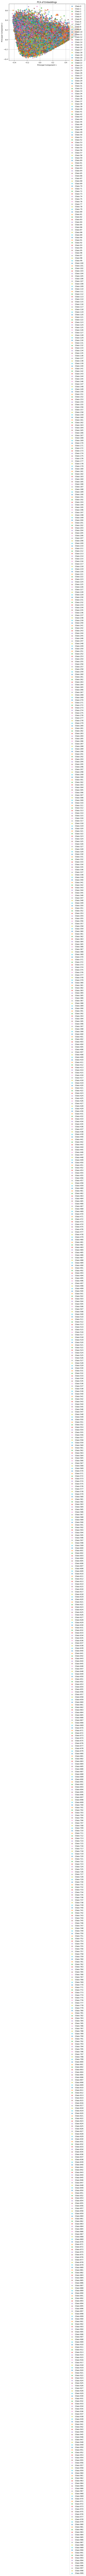

In [13]:
# Collect all embeddings and labels from the test set
def get_embeddings(model, test_loader, device):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            proto, output = model.get_proto(images)
            embeddings.append(proto.cpu())
            labels.append(targets.cpu())

    embeddings = torch.cat(embeddings, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return embeddings, labels

# Perform PCA and plot
def plot_pca(embeddings, labels, n_components=2):
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"Class {label}", alpha=0.6)
    
    plt.title("PCA of Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

embeddings, labels = get_embeddings(model, test_loader, device)
plot_pca(embeddings, labels)